## The main challange of this TPSFEB2022 is some of the bacterias is mutated and its becomes difficult to classify it. Can we use Denoising Autoencode (DAE) in this scenario? Let's investigate

<div style="background-color:rgba(255, 69, 0, 0.5);border-radius:5px;display:fill">
    <h1><center>Background</center></h1>
</div>

If we imagine that the MNIST digits images were corrupted by noise, thus making it harder for humans to read. In such scenarioa Denoising Autoencoder (DAE) can be used to remove the noise from these images. The basic concept is shown below

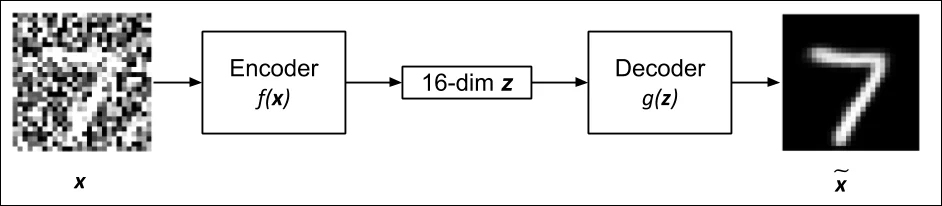

Typically, Denoising auto-encoder forces the hidden layer to extract more robust features and restrict it from merely learning the identity. Autoencoder reconstructs the input from a corrupted version of it. 

In summary, a denoising auto-encoder does two things:
Encode the input (preserve the information about the data)
Undo the effect of a corruption process stochastically applied to the input of the auto-encoder.
For the depiction of the denoising capabilities of Autoencoders, we’ll use noisy images as input and the original, clean images as targets.



In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import os 
import pandas as pd 
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from math import factorial
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
import gc
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.compose import make_column_transformer
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Model, Sequential
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

<div style="background-color:rgba(255, 69, 0, 0.5);border-radius:5px;display:fill">
    <h1><center>Loading data</center></h1>
</div>
The traing and testing dataset included the clustering information which was build using PCA, LDA, SVD. 
See my other notebook for full details
https://www.kaggle.com/abdulravoofshaik/its-all-about-clustering-lb-98-34

In [ ]:
# Reading train and testing datasets
output = pd.read_csv('/kaggle/input/tabular-playground-series-feb-2022/sample_submission.csv')
train_df = pd.read_csv('../input/tpsfeb2022-v2/train_cluster_target.csv')
test_df = pd.read_csv('../input/tpsfeb2022-v2/test_cluster_target.csv')
kagg_results=pd.read_csv('../input/tpsfeb2022-v3/test_cluster_withSStarget.csv')


In [ ]:
train_df=train_df.drop(['sample_weight'], axis = 1)
train_df.head()

In [ ]:
kagg_results.tail()

In [ ]:
#train_df3=pd.concat(train_df,kagg_results)
train_df = pd.concat([train_df,kagg_results],ignore_index=True,axis=0)


<div style="background-color:rgba(255, 69, 0, 0.5);border-radius:5px;display:fill">
    <h1><center>Optimzing the memory usage</center></h1>
</div>

In [ ]:

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)

In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
features = [feat for feat in test_df.columns if feat != 'Id' and feat != 'Cover_Type']

data_pipe_transformer = make_pipeline(
    StandardScaler()
)

preprocessor = make_column_transformer(
    (data_pipe_transformer, features)
)

In [ ]:
le = LabelEncoder()
train_df["target"] = le.fit_transform(train_df["target"])
target = le.fit_transform(train_df.target)

train_df.head()

In [ ]:
#train_df = train_df.iloc[:1000 , :]
train_df.tail()

In [ ]:
RUNS = 1
FOLDS = 10 # 10 # For debugging, change this when you use this notebook!
SEED = 2021
EPOCHS = 100 #0 # 90 # For debugging, change this when you use this notebook!
VERBOSE = 1
LR = 0.00012
BATCH_SIZE =32 #1024 

<div style="background-color:rgba(255, 69, 0, 0.5);border-radius:5px;display:fill">
    <h1><center>Creating DAE encoder</center></h1>
</div>

In [ ]:
class SwapRowNoise:
    def __init__(self, proba):
        self.proba = proba
    
    def apply(self, X):
        random_idx = np.random.randint(low=0, high=X.shape[0], size=1)[0]
        swap_matrix = K.random_bernoulli(shape=X.shape, p=self.proba) * tf.ones(shape=X.shape)    
        corrupted = tf.where(swap_matrix==1, X.iloc[random_idx], X)
        return corrupted.numpy()
    
# create autoencoder
class EncodingLayer(layers.Layer):
    def __init__(self, encoding_dim, activation='relu'):
        super().__init__()
        self.enc1 = layers.Dense(encoding_dim, activation)
        self.enc2 = layers.Dense(encoding_dim, activation)
        self.enc3 = layers.Dense(encoding_dim, activation)
        self.concat = layers.Concatenate()
    
    def call(self, inputs):
        enc1 = self.enc1(inputs)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        merge = self.concat([enc1, enc2, enc3])
        return merge

class DecodingLayer(layers.Layer):
    def __init__(self, num_outputs, activation='linear'):
        super().__init__()
        self.dec = layers.Dense(num_outputs, activation)
    
    def call(self, inputs):
        return self.dec(inputs)   

# create custom layer
class DenseBlock(layers.Layer):
    def __init__(self, units, activation='relu', dropout_rate=0, l2=0):
        super().__init__()
        self.dense = layers.Dense(
            units, activation,
            kernel_regularizer=keras.regularizers.l2(l2)
        )
        self.batchn = layers.BatchNormalization()
        self.dropout = layers.Dropout(dropout_rate)
    
    def call(self, inputs):
        x = self.dense(inputs)
        x = self.batchn(x)
        x = self.dropout(x)
        return x

In [ ]:
# create Auto-Encoder NN
class AutoEncoder(keras.Model):
    def __init__(self, encoding_dim, num_outputs, activation='relu'):
        super().__init__()
        self.encoder = EncodingLayer(encoding_dim, activation,)
        self.decoder = DecodingLayer(num_outputs)
    
    def call(self, inputs):
        encoder = self.encoder(inputs)
        decoder = self.decoder(encoder)
        return decoder
    
    def get_encoder(self):
        return self.encoder
        
# Create Fully-Connected NN
class MLP(keras.Model):
    def __init__(self, hidden_layers, autoencoder, activation='relu', dropout_rate=0, l2=0):
        super().__init__()
        self.encoder = autoencoder.get_encoder()
        self.hidden_layers = [DenseBlock(units, activation, l2) for units in hidden_layers]
        self.softmax = layers.Dense(units=len(le.classes_), activation='softmax')
        self.concat = layers.Concatenate()
        
    def call(self, inputs):
        x = self.encoder(inputs)
        for layer in self.hidden_layers:
            x = layer(x)
        x = self.softmax(x)
        return x   

In [ ]:
total_oof_list = []
test_pred_list = []
train_df.Cover_Type=train_df.target
#TPU = True
TPU = False
from tensorflow.keras import backend as K
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
    
print('Replicas:', strategy.num_replicas_in_sync)

<div style="background-color:rgba(255, 69, 0, 0.5);border-radius:5px;display:fill">
    <h1><center>Training the model</center></h1>
</div>

In [ ]:
np.random.seed(2021)
tf.random.set_seed(2021)

score_list, history_list = [], []
oof_list = [np.full((len(train_df), len(le.classes_)), -1.0, dtype='float32') for run in range(RUNS)]
for run in range(RUNS):
    kf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=1)
    for fold, (train_idx, val_idx) in enumerate(kf.split(train_df, y=train_df.Cover_Type)):
        print(f"Fold {run}.{fold}")
        K.clear_session()
        
        X_tr = train_df.iloc[train_idx]
        X_va = train_df.iloc[val_idx]
        y_tr = target[train_idx]
        y_va = target[val_idx]
        X_tr = X_tr[features]
        X_va = X_va[features]

        X_tr[features] = preprocessor.fit_transform(X_tr)
        X_va[features] = preprocessor.transform(X_va)

        noise_maker = SwapRowNoise(0.10)
        X_noise_train = noise_maker.apply(X_tr)
        X_noise_valid = noise_maker.apply(X_va)

        # TPU model
        if TPU:
            with strategy.scope():
                ae = AutoEncoder(encoding_dim=128,num_outputs=X_tr.shape[-1],activation='relu')
                ae.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),loss=keras.losses.MeanSquaredError())
            lr = ReduceLROnPlateau(monitor = "val_loss", factor = 0.5, patience = 5, verbose = VERBOSE)
            es = EarlyStopping(monitor = "val_loss", patience = 10, verbose = VERBOSE, mode = "min", restore_best_weights = True)
            history_ae = ae.fit(X_noise_train, X_tr,validation_data=(X_noise_valid, X_va),epochs=EPOCHS,batch_size=BATCH_SIZE,validation_batch_size=BATCH_SIZE,shuffle=True,verbose=False,callbacks=[lr,es])

            with strategy.scope():
                model = MLP(hidden_layers=[32,32,32],autoencoder=ae,activation='relu')
                model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),loss="sparse_categorical_crossentropy",metrics=['acc'])

        else:
            # GPU model
            ae = AutoEncoder(encoding_dim=128,num_outputs=X_tr.shape[-1],activation='relu')
            ae.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),loss=keras.losses.MeanSquaredError())
            lr = ReduceLROnPlateau(monitor = "val_loss", factor = 0.5, patience = 5, verbose = VERBOSE)
            es = EarlyStopping(monitor = "val_loss", patience = 10, verbose = VERBOSE, mode = "min", restore_best_weights = True)
            history_ae = ae.fit(X_noise_train, X_tr,validation_data=(X_noise_valid, X_va),epochs=EPOCHS,batch_size=BATCH_SIZE,validation_batch_size=BATCH_SIZE,shuffle=True,verbose=False,callbacks=[lr,es])

            model = MLP(hidden_layers=[32,32],autoencoder=ae,activation='relu')
            model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),loss="sparse_categorical_crossentropy",metrics=['acc'])

        lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5,
                               patience=5, verbose=VERBOSE)

        es = EarlyStopping(monitor="val_acc", patience=10,
                           verbose=VERBOSE, mode="max",
                           restore_best_weights=True)

        history = model.fit(X_tr, y_tr,
                            validation_data=(X_va, y_va),
                            epochs=EPOCHS,
                            verbose=VERBOSE,
                            batch_size=BATCH_SIZE,
                            validation_batch_size=BATCH_SIZE,
                            shuffle=True,
                            callbacks=[lr, es])
        history_list.append(history.history)

        y_va_pred = model.predict(X_va, batch_size=len(X_va))
        oof_list[run][val_idx] = y_va_pred
        y_va_pred = le.inverse_transform(np.argmax(y_va_pred, axis=1))

        #accuracy = accuracy_score(train_df.iloc[val_idx].Cover_Type, y_va_pred)

       # print(f"Fold {run}.{fold} | Epochs: {len(history_list[-1]['loss'])} | Accuracy: {accuracy:.5f}")

        test_pred_list.append(model.predict(preprocessor.transform(test_df[features]), batch_size=BATCH_SIZE))

        del model, y_va_pred
        gc.collect()
total_oof_list += oof_list

In [ ]:
output['target'] = le.inverse_transform(np.argmax(sum(test_pred_list), axis=1)) 
print(output.head())


In [ ]:
#le2 = LabelEncoder()
#ss=le2.transform(train_df["target"])

train_df2 = pd.read_csv('../input/tpsfeb2022-v2/train_cluster_target.csv')
lb3 = LabelEncoder()
new_ls = lb3.fit(train_df2["target"])


<div style="background-color:rgba(255, 69, 0, 0.5);border-radius:5px;display:fill">
    <h1><center>Submission</center></h1>
</div>

In [ ]:
output['target'] =lb3.inverse_transform(output['target'] )

In [ ]:
output.head()

In [ ]:
output.to_csv('submission.csv', index=False)

## Don't forget to upvote if you find it useful 😁😁



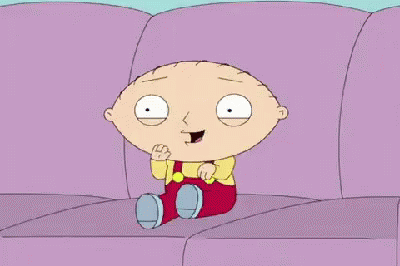

# Way forward

1) Include common samples from train and test datasets

2) Try blending with my other notebook results

## References:

https://subscription.packtpub.com/book/big_data_and_business_intelligence/9781788629416/3/ch03lvl1sec19/denoising-autoencoder-dae

http://www.opendeep.org/v0.0.5/docs/tutorial-your-first-model

https://medium.com/analytics-vidhya/reconstruct-corrupted-data-using-denoising-autoencoder-python-code-aeaff4b0958e

https://www.kaggle.com/abdulravoofshaik/its-all-about-clustering-lb-98-34

https://www.kaggle.com/springmanndaniel/1st-place-turn-your-data-into-daeta

https://simg.nicepng.com/png/small/137-1379308_website-work-in-progress.png

Notebooks of YAM PELEG

https://www.kaggle.com/lisyuan0930/tps-feb-resnet/notebook

